# Data Integration
---

Samples from three different datasets ([Jiang *et al.* 2022](https://doi.org/10.1002/ctm2.730), [Kim *et al.* 2022](https://doi.org/10.1038/s41698-022-00251-1),
[Kumar *et al.* 2022](http://doi.org/10.1158/2159-8290.CD-21-0683)), representing patients with gastric adenocarcinoma at various stages and subtypes (intestinal, diffuse, and mixed), were analyzed together in a meta-analysis. Each sample was paired, with both tumor and adjacent normal tissue collected from the same patient. The aim of this analysis was to infer common molecular patterns and identify potential biomarkers across these patient groups. (For more detailed information about each sample, see *metadata.csv*.)

To address the batch effects that arise between groups of cells within an experiment, between experiments in the same laboratory, or between datasets from different laboratories, data integration will be applied. However, before integration, each sample was preprocessed using the **`qc_norm.py`** script. This script performs quality control steps such as filtering low-quality cells, removing ambient RNA contamination with DecontX, and detecting doublets with scDblFinder. While the script also applies sample-specific normalization using both shifted log normalization and scran normalization, this step is not required for the following downstream analysis, as the scVI integration method uses raw counts.



In [ ]:
# install required packages
!pip install scanpy scvi-tools

In [ ]:
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

In [ ]:
# set working directory
wdir = '/content/GC_scRNAseq_processed/'
os.chdir(wdir)
os.getcwd()

'/content/GC_scRNAseq_processed'

In [ ]:
# get dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/GC_scRNAseq_processed.zip')
zip_ref.extractall('/content/')
zip_ref.close()

## Concatenate Samples
---


Before integration, all sample-specific AnnData objects need to be concatenated into a single common AnnData object.

In [ ]:
# list processed .h5ad files
adata_files = [file for file in os.listdir() if file.endswith('_processed.h5ad')]
adata_files.sort()
adata_files


['Jiang_et_al_2022_NT1_processed.h5ad',
 'Jiang_et_al_2022_PT2_processed.h5ad',
 'Kim_et_al_2022_Pat01-A_processed.h5ad',
 'Kim_et_al_2022_Pat01-B_processed.h5ad',
 'Kim_et_al_2022_Pat02-A_processed.h5ad',
 'Kim_et_al_2022_Pat02-B_processed.h5ad',
 'Kim_et_al_2022_Pat03-A_processed.h5ad',
 'Kim_et_al_2022_Pat03-B_processed.h5ad',
 'Kim_et_al_2022_Pat04-A_processed.h5ad',
 'Kim_et_al_2022_Pat04-B_processed.h5ad',
 'Kim_et_al_2022_Pat05-A_processed.h5ad',
 'Kim_et_al_2022_Pat05-B_processed.h5ad',
 'Kim_et_al_2022_Pat06-A_processed.h5ad',
 'Kim_et_al_2022_Pat06-B_processed.h5ad',
 'Kim_et_al_2022_Pat07-A_processed.h5ad',
 'Kim_et_al_2022_Pat07-B_processed.h5ad',
 'Kim_et_al_2022_Pat08-A_processed.h5ad',
 'Kim_et_al_2022_Pat08-B_processed.h5ad',
 'Kim_et_al_2022_Pat09-A_processed.h5ad',
 'Kim_et_al_2022_Pat09-B_processed.h5ad',
 'Kim_et_al_2022_Pat10-A_processed.h5ad',
 'Kim_et_al_2022_Pat10-B_processed.h5ad',
 'Kim_et_al_2022_Pat11-A_processed.h5ad',
 'Kim_et_al_2022_Pat11-B_processed.h5a

In [ ]:
# clear memory
gc.collect()

33013

In [ ]:
output_file = '/content/GC_scRNAseq_concatenated.h5ad'
#adata_combined = None
adata_combined = sc.read_h5ad('/content/GC_scRNAseq_concatenated.h5ad', backed='r+') # if adata_combined already exist
#adata_combined = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_concatenated.h5ad', backed='r+') # if adata_combined already exist


# functions
def concatenate_and_write(adata_combined, adata_new, output_file):
    """
    Concatenate adata_combined with adata_new and write to disk.

    Args:
      adata_combined (anndata.AnnData): The existing combined AnnData object.
      adata_new (anndata.AnnData): The new AnnData object to add.
      output_file (str): The file path to write the combined AnnData object.

    """

    # concatenate
    temp_combined = sc.concat([adata_combined.to_memory(), adata_new], join='outer', merge='unique')
    # write to disk
    temp_combined.write(output_file, compression='gzip')
    # explicitly delete intermediate objects to free memory
    del adata_combined, temp_combined
    # force garbage collection
    gc.collect()


def convert_to_string(adata):
    """
    Convert all columns in adata.obs and adata.var to strings.

    Args:
      adata (anndata.AnnData): The AnnData object to modify.

    Returns:
      anndata.AnnData: The modified AnnData object.
    """

    for col in adata.obs.columns:
        adata.obs[col] = adata.obs[col].astype(str)
    for col in adata.var.columns:
        adata.var[col] = adata.var[col].astype(str)
    return adata


# main
for i, file in enumerate(adata_files[50:]):  # adjust range as needed - [:20] [20:40] [40:]
    print(f'Adding ({i}) {file}...')

    # read the AnnData file
    adata = sc.read_h5ad(file)
    # append unique suffix based on the file index to ensure global uniqueness
    adata.obs.index = [f"{name}_{file[:-15]}" for name in adata.obs.index]
    # convert all columns in adata.obs and adata.var to strings (since nullable string arrays not supported)
    adata = convert_to_string(adata)

    if adata_combined is None:
        # initialize the combined AnnData with the first file
        adata_combined = adata
        adata_combined.write(output_file, compression='gzip')
        adata_combined = sc.read_h5ad(output_file, backed='r+')
    else:
        # convert columns to string in the combined data as well
        adata_combined = convert_to_string(adata_combined.to_memory())
        # concatenate the new data with the existing combined data and write to disk
        concatenate_and_write(adata_combined, adata, output_file)
        adata_combined = sc.read_h5ad(output_file, backed='r+')

    # clear memory
    del adata
    gc.collect()

# close the backed file handle
adata_combined.file.close()

# final save to google drive
!cp /content/GC_scRNAseq_concatenated.h5ad /content/drive/MyDrive/GC_scRNAseq_concatenated.h5ad

print(f'Concatenation complete and saved to {output_file}')


Adding (0) Kumar_et_al_2022_sample21_processed.h5ad...
Adding (1) Kumar_et_al_2022_sample22_processed.h5ad...
Adding (2) Kumar_et_al_2022_sample23_processed.h5ad...
Adding (3) Kumar_et_al_2022_sample24_processed.h5ad...
Adding (4) Kumar_et_al_2022_sample25_processed.h5ad...
Adding (5) Kumar_et_al_2022_sample26_processed.h5ad...
Adding (6) Kumar_et_al_2022_sample2_processed.h5ad...
Adding (7) Kumar_et_al_2022_sample4_processed.h5ad...
Adding (8) Kumar_et_al_2022_sample5_processed.h5ad...
Adding (9) Kumar_et_al_2022_sample6_processed.h5ad...
Adding (10) Kumar_et_al_2022_sample7_processed.h5ad...
Adding (11) Kumar_et_al_2022_sample9_processed.h5ad...
Concatenation complete and saved to /content/GC_scRNAseq_concatenated.h5ad


## Integrate Data with scVI
---


The scVI (single-cell Variational Inference) method ([Gayoso *et al.* 2022](http://doi.org/10.1038/s41587-021-01206-w)) uses a conditional variational autoencoder to reduce dimensionality in single-cell RNA-seq data while correcting for batch effects by accounting for covariates like batches. It operates directly on raw counts, ensuring effective batch correction without compromising biological variability.

In [ ]:
# read concatenated .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_concatenated.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    layers: 'counts', 'decontX_counts', 'log1p_norm', 'scran_norm'

### Number of Cells per Dataset

In [ ]:
# number of cells per dataset
adata.obs['dataset'].value_counts()

,count
dataset,
Kim_et_al_2022,131785
Kumar_et_al_2022,36859
Jiang_et_al_2022,8141


### Unintegrated Data

In [ ]:
# normalize across combined dataset
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log1p_norm_concat'] = adata.X.copy()

In [ ]:
# umap of unintegrated data
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX_counts', 'log1p_norm', 'scran_norm', 'log1p_norm_concat'
    obsp: 'distances', 'connectivities'

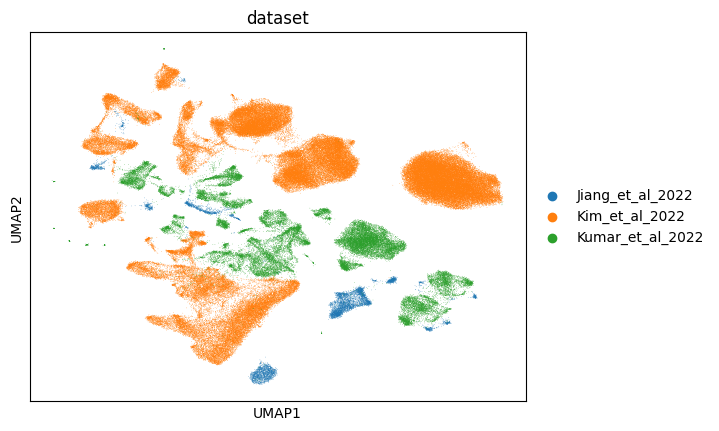

In [ ]:
# plot umap of unintegrated data
sc.pl.umap(adata, color=['dataset'])

### Batch-aware Feature Selection

Selecting a subset of highly variable genes for integration minimizes noise and processing time, focusing on key biological signals. Batch-aware feature selection prevents the inclusion of genes driven by batch effects and also ensures that markers for rare cell identities are retained.

The ideal number of highly variable genes (HVGs) to select for integration typically ranges between 1000 and 6000, depending on dataset complexity and batch effects. While fewer genes can help remove batch effects, selecting slightly more is recommended to avoid excluding important genes for rare cell types or key pathways, balancing accuracy and processing time. (see also *https://www.sc-best-practices.org/cellular_structure/integration.html*)

1) Select the 2000 most highly variable genes:

In [ ]:
# batch-aware feature selection
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor='cell_ranger', batch_key='batch'
)
adata
adata.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
A1BG,False,0.096973,0.689797,0.342665,12,False
A1BG-AS1,False,0.007516,0.757508,0.469262,6,False
A1CF,False,0.006677,0.580045,-0.256936,3,False
A2M,True,0.126347,1.359601,7.966991,62,True
A2M-AS1,True,0.003173,0.823919,1.099828,24,False
...,...,...,...,...,...,...
ZYG11A,False,0.000428,0.382479,0.242166,5,False
ZYG11B,False,0.020431,0.656792,-0.292832,1,False
ZYX,False,0.104140,0.733941,0.775491,11,False
ZZEF1,False,0.033041,0.710667,0.365430,2,False


,count
highly_variable_nbatches,
0,11822
1,4696
2,2378
3,1474
4,985
...,...
33,30
34,29
50,29


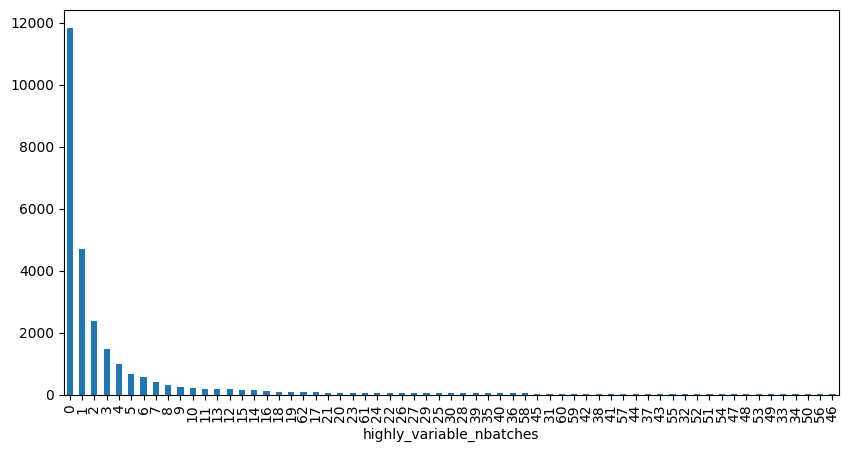

In [ ]:
# how many batches each gene was variable in
n_batches = adata.var['highly_variable_nbatches'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
n_batches.plot(kind="bar", ax=ax);
n_batches


In [ ]:
# create AnnData object with just the 2k selected highly variable genes
adata_hvg2k = adata[:, adata.var['highly_variable']].copy()
adata_hvg2k

AnnData object with n_obs × n_vars = 176785 × 2000
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX_counts', 'log1p_norm', 'scran_norm', 'log1p

2) Select the 3000 most highly vaiable genes:

In [ ]:
# batch-aware feature selection
sc.pp.highly_variable_genes(
    adata, n_top_genes=3000, flavor='cell_ranger', batch_key='batch'
)
adata
adata.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
A1BG,False,0.096973,0.689797,0.342665,17,False
A1BG-AS1,True,0.007516,0.757508,0.469262,19,False
A1CF,False,0.006677,0.580045,-0.256936,6,False
A2M,True,0.126347,1.359601,7.966991,62,True
A2M-AS1,True,0.003173,0.823919,1.099828,34,False
...,...,...,...,...,...,...
ZYG11A,False,0.000428,0.382479,0.242166,9,False
ZYG11B,False,0.020431,0.656792,-0.292832,2,False
ZYX,True,0.104140,0.733941,0.775491,22,False
ZZEF1,False,0.033041,0.710667,0.365430,6,False


,count
highly_variable_nbatches,
0,7730
1,4339
2,2505
3,1771
4,1346
...,...
44,41
51,39
39,37


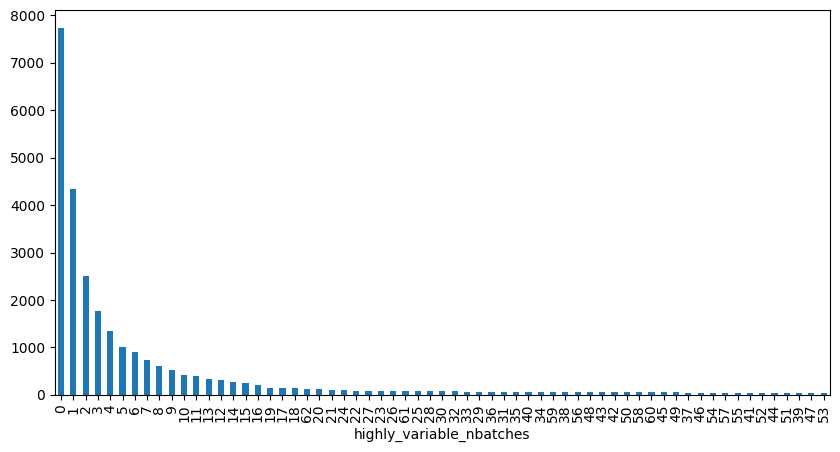

In [ ]:
# how many batches each gene was variable in
n_batches = adata.var['highly_variable_nbatches'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
n_batches.plot(kind="bar", ax=ax);
n_batches

In [ ]:
# create AnnData object with just the 3k selected highly variable genes
adata_hvg3k = adata[:, adata.var['highly_variable']].copy()
adata_hvg3k

AnnData object with n_obs × n_vars = 176785 × 3000
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX_counts', 'log1p_norm', 'scran_norm', 'log1p

### Get Embedding



In [ ]:
# set seed
scvi.settings.seed = 42

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Based on the 2000 most highly varaibale genes:

In [ ]:
# prepare data for scvi data integration
scvi.model.SCVI.setup_anndata(adata_hvg2k, layer='counts', batch_key='batch', categorical_covariate_keys=['dataset', 'patient'])
adata_hvg2k

AnnData object with n_obs × n_vars = 176785 × 2000
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categoric

In [ ]:
# build scvi model
model_scvi_hvg2k = scvi.model.SCVI(adata_hvg2k)
model_scvi_hvg2k

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
# train scvi model
model_scvi_hvg2k.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 45/45: 100%|██████████| 45/45 [12:55<00:00, 17.04s/it, v_num=1, train_loss_step=839, train_loss_epoch=557]   

INFO: `Trainer.fit` stopped: `max_epochs=45` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.


Epoch 45/45: 100%|██████████| 45/45 [12:55<00:00, 17.24s/it, v_num=1, train_loss_step=839, train_loss_epoch=557]


In [ ]:
# extract embedding
adata_hvg2k.obsm['X_scVI_hvg2k'] = model_scvi_hvg2k.get_latent_representation()

In [ ]:
# umap of batch-corrected data
sc.pp.neighbors(adata_hvg2k, use_rep='X_scVI_hvg2k')
sc.tl.umap(adata_hvg2k)
adata_hvg2k

AnnData object with n_obs × n_vars = 176785 × 2000
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categoric

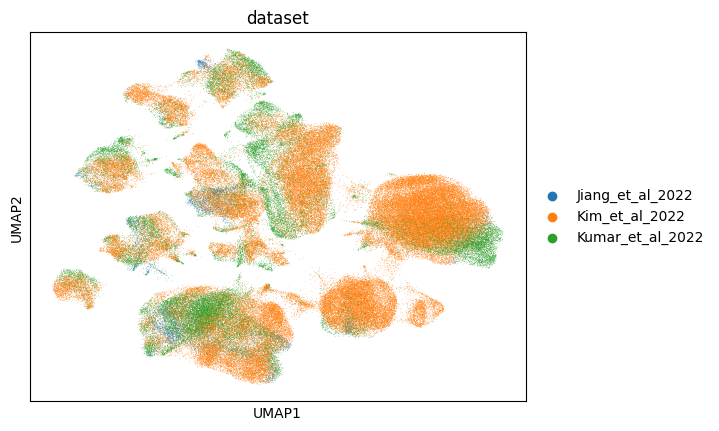

In [ ]:
# plot umap of batch-corrected data - hvg 2k & 2 categorical covariates dataset and patient
sc.pl.umap(adata_hvg2k, color=['dataset'])

In [ ]:
# add the latent representation and umap to original AnnData object with all genes
adata.obsm['X_scVI_hvg2k'] = model_scvi_hvg2k.get_latent_representation()

Based on the 3000 most highly varaibale genes:

In [ ]:
# prepare data for scvi data integration
scvi.model.SCVI.setup_anndata(adata_hvg3k, layer='counts', batch_key='batch', categorical_covariate_keys=['dataset', 'patient'])
adata_hvg3k

AnnData object with n_obs × n_vars = 176785 × 3000
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categoric

In [ ]:
# build scvi model
model_scvi_hvg3k = scvi.model.SCVI(adata_hvg3k)
model_scvi_hvg3k

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
# train scvi model
model_scvi_hvg3k.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 45/45: 100%|██████████| 45/45 [13:44<00:00, 19.45s/it, v_num=1, train_loss_step=768, train_loss_epoch=763]

INFO: `Trainer.fit` stopped: `max_epochs=45` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.


Epoch 45/45: 100%|██████████| 45/45 [13:44<00:00, 18.32s/it, v_num=1, train_loss_step=768, train_loss_epoch=763]


In [ ]:
# extract embedding
adata_hvg3k.obsm['X_scVI_hvg3k'] = model_scvi_hvg3k.get_latent_representation()

In [ ]:
# umap of batch-corrected data
sc.pp.neighbors(adata_hvg3k, use_rep="X_scVI_hvg3k")
sc.tl.umap(adata_hvg3k)
adata_hvg3k

AnnData object with n_obs × n_vars = 176785 × 3000
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categoric

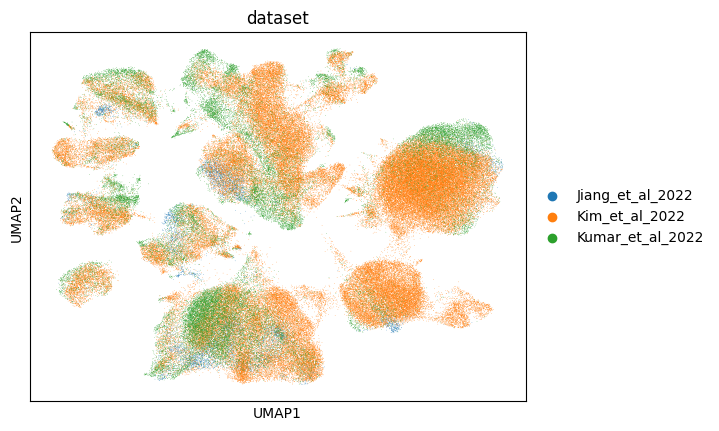

In [ ]:
# plot umap of batch-corrected data - hvg 3k & 2 categorical covariates dataset and patient
sc.pl.umap(adata_hvg3k, color=['dataset'])

In [ ]:
# add the latent representation and umap to original AnnData object with all genes
adata.obsm['X_scVI_hvg3k'] = model_scvi_hvg3k.get_latent_representation()

In [ ]:
# save .h5ad
adata.write('/content/drive/MyDrive/GC_scRNAseq_integrated.h5ad', compression='gzip')

### Get Integrated, Normalized Gene Counts - Train Model

In [ ]:
# read .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_integrated.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    obsm: 'X_scVI_hvg2k', 'X_scVI_hvg3k'
    layers: 'counts', 'decontX_counts', 'log1p_norm', 'log1p_norm_concat', 'scran_norm'

In [ ]:
# prepare data for scvi data integration
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='batch', categorical_covariate_keys=['dataset', 'patient'])

In [ ]:
# build scvi model
model_scvi = scvi.model.SCVI(adata)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
# train scvi model
model_scvi.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 45/45: 100%|██████████| 45/45 [34:41<00:00, 46.95s/it, v_num=1, train_loss_step=4.19e+3, train_loss_epoch=3.93e+3]

INFO: `Trainer.fit` stopped: `max_epochs=45` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.


Epoch 45/45: 100%|██████████| 45/45 [34:41<00:00, 46.26s/it, v_num=1, train_loss_step=4.19e+3, train_loss_epoch=3.93e+3]


In [ ]:
model_scvi.save('/content/drive/MyDrive/model_scvi')

Save the trained model to later retrieve integrated normalized gene counts for specific subsets of cells (see *NB3_compositional_and_DE_analyses.ipynb*)

---

In [2]:
!pip list

Package                          Version
-------------------------------- -------------------
absl-py                          1.4.0
accelerate                       0.34.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.16
albumentations                   1.4.15
altair                           4.2.2
anndata                          0.10.8
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_api_compat                 1.8
array_record                     0.5.1
arviz                            0.19.0
astropy                          6.1.3
astropy-iers-data                0.2024.9.16.0.32.21
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                      